# Plot ridgelines

## Import python libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
import netCDF4 as nc4
from pyproj import Proj, transform, Transformer, CRS

# for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import cmocean
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Load data

In [2]:
# import bathymetry data
bedmachine_ds = xr.open_dataset('../../../../data/bathymetry/BedMachine_v5_regions/bedmachineV5_moorings_region.nc')

In [3]:
# create mask for only bathymetry values less than zero (below surface) - set values > 0 to zero.
bed_masked_ds = bedmachine_ds.bed.where(bedmachine_ds.bed<0, 0)

Load csv files for thalweg and reference line

In [4]:
# import all transect data
transect_csv_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/QGIS_files/')

# important transect csv files
rink_transect_points_df = pd.read_csv(transect_csv_dir/'rink_thalweg.csv')
kong_transect_points_df = pd.read_csv(transect_csv_dir/'kongoscar_thalweg.csv')
sver_transect_points_df = pd.read_csv(transect_csv_dir/'sverdrup_thalweg.csv')

# import reference line csv files
rink_ref_points_df = pd.read_csv(transect_csv_dir/'rink_parallel_bent_points.csv')
kong_ref_points_df = pd.read_csv(transect_csv_dir/'kongoscar_parallel_bent_points.csv')
sver_ref_points_df = pd.read_csv(transect_csv_dir/'sverdrup_parallel_points.csv')

### Plot on map

In [5]:
# function that reprojects lat/lon coordinates to polar stereographic
# lat/lon coordinates are needed to plot properly below
def transform_projection_to_Npolar(line_da):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
    xx, yy = transformer.transform(line_da.lon.values, line_da.lat.values)
    return xx,yy

In [6]:
def plot_ridgelines(location, transect_points_df, ref_points_df):
    ## open datasets (ridge, ridge smoothed, and search lines) ================================
    ridge_minus_ds = xr.open_dataset("netcdfs/" + location + "_ridgeline_minus.nc")
    ridge_plus_ds  = xr.open_dataset("netcdfs/" + location + "_ridgeline_plus.nc")
    ridge_minus_ds.close()
    ridge_plus_ds.close()
    
    ridge_minus_smooth_ds = xr.open_dataset("netcdfs/" + location + "_ridgeline_minus_smooth.nc")
    ridge_plus_smooth_ds  = xr.open_dataset("netcdfs/" + location + "_ridgeline_plus_smooth.nc")
    ridge_minus_smooth_ds.close()
    ridge_plus_smooth_ds.close()
    
    lines_minus_ds = xr.open_dataset("netcdfs/" + location + "_lines_minus.nc")
    lines_plus_ds  = xr.open_dataset("netcdfs/"+ location + "_lines_plus.nc")
    lines_minus_ds.close()
    lines_plus_ds.close()
    
    # reproject lat/lon coords to Polar to plot with BedMachine
    ridge_minus_x, ridge_minus_y = transform_projection_to_Npolar(ridge_minus_ds.ridgeline_minus)
    ridge_plus_x, ridge_plus_y   = transform_projection_to_Npolar(ridge_plus_ds.ridgeline_plus)
    
    ridge_minus_smooth_x, ridge_minus_smooth_y = transform_projection_to_Npolar(ridge_minus_smooth_ds.ridgeline_minus_smooth)
    ridge_plus_smooth_x, ridge_plus_smooth_y   = transform_projection_to_Npolar(ridge_plus_smooth_ds.ridgeline_plus_smooth)
    
    ## PLOT =====================================================================================
    fig = plt.figure(figsize=(10,12)) # width, height
    plt.rcParams['font.size'] = '12'
    
    ## add two subplots
    ## set geographic extent of plots
    if location == "rink":
        extent = [-63.5, -60, 76.05, 76.55]
    elif location == "kongoscar":
        extent = [-62.6, -58.5, 75.65, 76.3]
    elif location == "sverdrup":
        extent = [-61.2, -57, 75.35, 76]
    
    ax1 = fig.add_subplot(2,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
    ax1.set_extent(extent, ccrs.PlateCarree())
    ax2 = fig.add_subplot(2,1,2, projection=ccrs.NorthPolarStereo(central_longitude = -45))
    ax2.set_extent(extent, ccrs.PlateCarree())
        
    ## set up both maps
    for ax in [ax1,ax2]:
        # define top and bottom colormaps 
        bathy = cm.get_cmap(cmocean.cm.diff, 21)
        surface = (.5, .5, .5, 1.0)
        newcolors = np.vstack((bathy(np.linspace(0, 0.4, 21)),
                               surface)) # create a new colormaps
        ocean_land = ListedColormap(newcolors, name='ocean_land')
        bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
        ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0]
    
        pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                           shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False,extend='both')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
        # plot thalweg line
        ax.plot(transect_points_df.x,transect_points_df.y,'k',transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                 linewidth=0.9, label='thalweg')
    
    ## upper subplot ==============================================
    # plot reference line
    ax1.plot(ref_points_df.x, ref_points_df.y,'tab:orange', transform=ccrs.NorthPolarStereo(central_longitude = -45),\
             label='reference line')
    # plot search lines and maximum elevation selected (before smoothing)
    for i in range(len(lines_minus_ds.distance)):
        xx, yy = transform_projection_to_Npolar(lines_minus_ds.isel(distance=i))
        ax1.plot(xx,yy,c='k',linewidth=0.5,transform=ccrs.NorthPolarStereo(central_longitude = -45))
    for i in range(len(lines_plus_ds.distance)):
        xx, yy = transform_projection_to_Npolar(lines_plus_ds.isel(distance=i))
        ax1.plot(xx,yy,c='k',linewidth=0.5,transform=ccrs.NorthPolarStereo(central_longitude = -45))
    # maximum
    ax1.plot(xx,yy,c='k',linewidth=0.4,transform=ccrs.NorthPolarStereo(central_longitude = -45),label="search lines") # for legend entry
    ax1.plot(ridge_minus_x, ridge_minus_y,'x-',markersize=3,linewidth=0.1,color='y',\
             transform=ccrs.NorthPolarStereo(central_longitude = -45),label="elevation maximum")
    ax1.plot(ridge_plus_x, ridge_plus_y,'x-',markersize=3,linewidth=0.1,color='y',\
             transform=ccrs.NorthPolarStereo(central_longitude = -45))
    
    ## lower subplot ==============================================
    # plot ridgelines
    ax2.plot(ridge_minus_x, ridge_minus_y,'xk-',linewidth=0.5, transform=ccrs.NorthPolarStereo(central_longitude = -45),\
             label='ridge')
    ax2.plot(ridge_plus_x, ridge_plus_y,'xk-',linewidth=0.5, transform=ccrs.NorthPolarStereo(central_longitude = -45))
    ax2.plot(ridge_minus_smooth_x, ridge_minus_smooth_y,'.r-',markersize=3,linewidth=0.5,\
             transform=ccrs.NorthPolarStereo(central_longitude = -45), label='ridge (smooth)')
    ax2.plot(ridge_plus_smooth_x, ridge_plus_smooth_y,'.r-',markersize=3,linewidth=0.5,\
             transform=ccrs.NorthPolarStereo(central_longitude = -45))
    
    ax1.legend(loc='upper left');
    ax2.legend(loc='upper left');
    
    ## add colorbar to upper subplot ==============================
    axins = inset_axes(
        ax1,
        width="3%",  # width: 5% of parent_bbox width
        height="100%",
        loc="upper left",
        bbox_to_anchor=(1.05, 0., 1, 1),
        bbox_transform=ax1.transAxes,
        borderpad=0)
    cb = fig.colorbar(pc, label='Elevation (m)',cax=axins,ticks=ticks,boundaries=bounds,orientation='vertical',\
                        shrink=0.7,spacing='uniform',pad=0.005,aspect=30, extend='both')
    tick_labs = [-1000,"",-900,"",-800,"",-700,"",-600,"",-500,"",-400,"",-300,"",-200,"",-100,"",0]
    cb.ax.set_yticklabels(tick_labs);
    
    ## add titles and adjust plot settings
    ax1.set_title("(a)", loc='left', size=16)
    ax2.set_title("(b)", loc='left', size=16)
    plt.subplots_adjust(hspace=0.1);
    
    filename = str("../figures/" + location + "_ridgelines.png")
    
    # save figure
    plt.savefig(filename, bbox_inches='tight', dpi=300, facecolor='white')

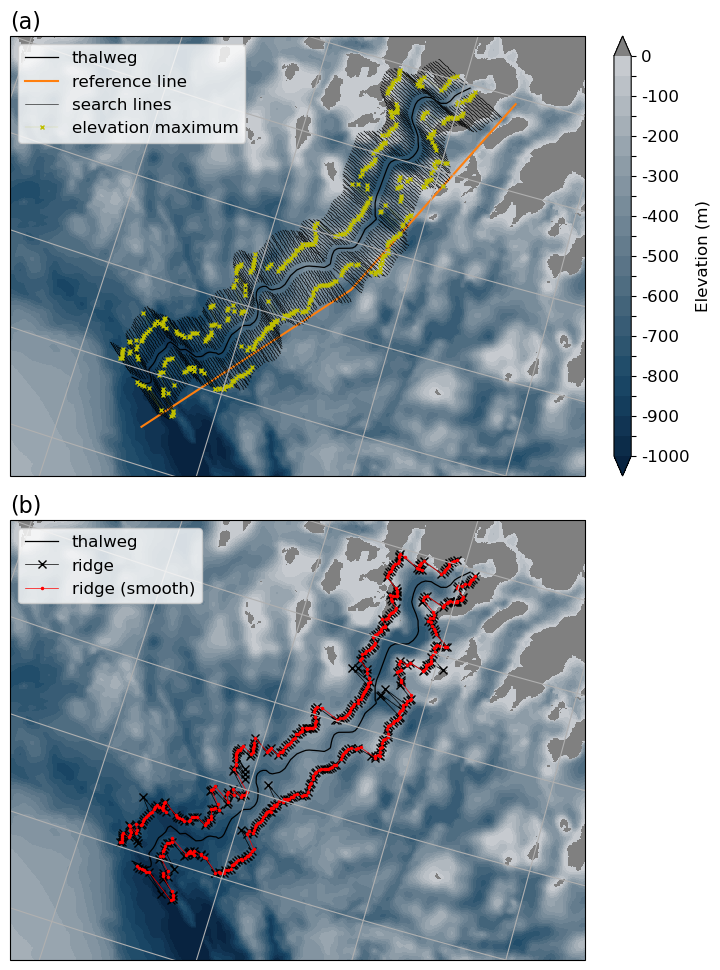

In [7]:
plot_ridgelines('rink', rink_transect_points_df, rink_ref_points_df)

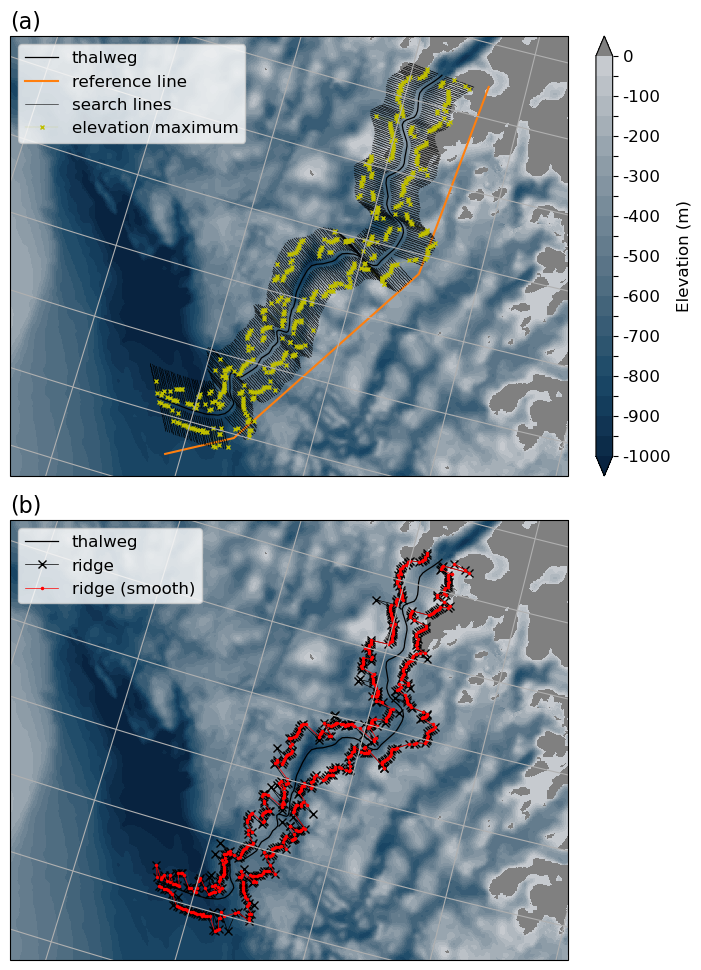

In [8]:
plot_ridgelines('kongoscar', kong_transect_points_df, kong_ref_points_df)

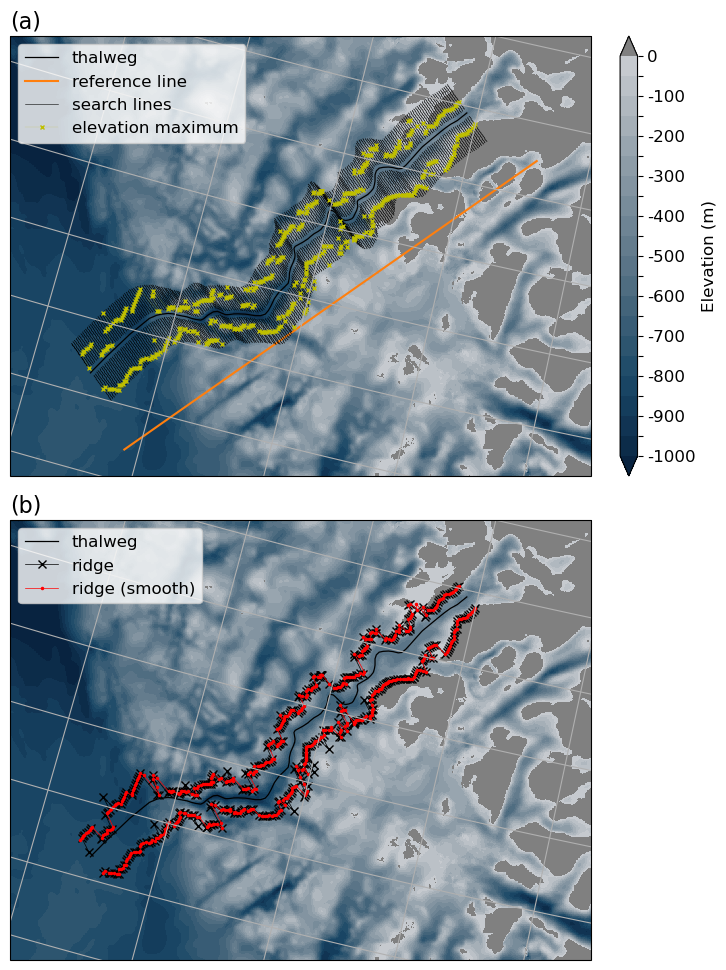

In [9]:
plot_ridgelines('sverdrup', sver_transect_points_df, sver_ref_points_df)

#### Plots showing elevation of ridgelines along transect before and after smoothing

In [7]:
# open ridgeline before and after smoothing
sver_ridge_minus_ds = xr.open_dataset("netcdfs/sverdrup_ridgeline_minus.nc")
sver_ridge_plus_ds  = xr.open_dataset("netcdfs/sverdrup_ridgeline_plus.nc")
sver_ridge_minus_ds.close()
sver_ridge_plus_ds.close()

# open smoothed datasets
sver_ridge_minus_smooth_ds = xr.open_dataset("netcdfs/sverdrup_ridgeline_minus_smooth.nc")
sver_ridge_plus_smooth_ds  = xr.open_dataset("netcdfs/sverdrup_ridgeline_plus_smooth.nc")
sver_ridge_minus_smooth_ds.close()
sver_ridge_plus_smooth_ds.close()

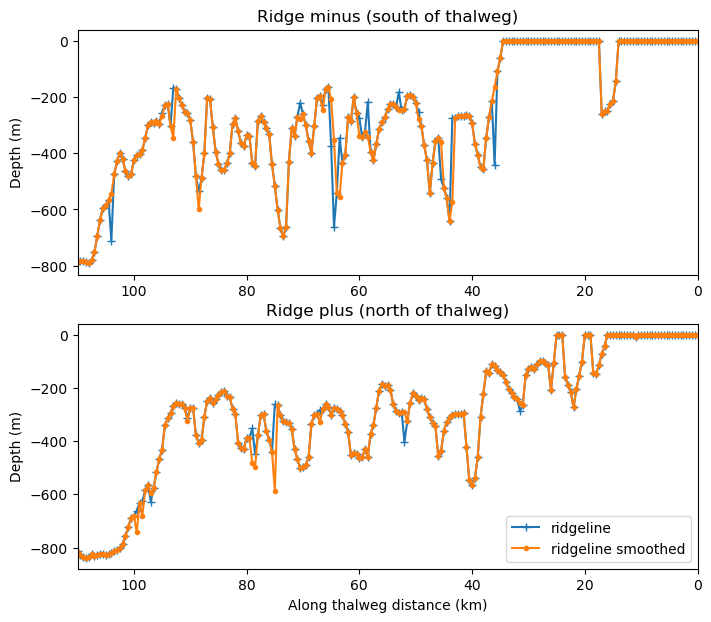

In [15]:
fig, (ax1, ax2) = plt.subplots(2)
plt.rcParams["figure.figsize"] = (8,7)
plt.rcParams['font.size'] = '10'

ax1.set_title("Ridge minus (south of thalweg)")
ax1.plot(sver_ridge_minus_ds.distance.values/1000, sver_ridge_minus_ds.ridgeline_minus.values, '+-')
ax1.plot(sver_ridge_minus_smooth_ds.distance.values/1000, sver_ridge_minus_smooth_ds.ridgeline_minus_smooth.values, '.-')
# ax1.set_xlabel("Along thalweg distance (km)")
ax1.set_ylabel("Depth (m)")
ax1.set_xlim(110,0);

ax2.set_title("Ridge plus (north of thalweg)")
ax2.plot(sver_ridge_plus_ds.distance.values/1000, sver_ridge_plus_ds.ridgeline_plus.values, '+-', label='ridgeline')
ax2.plot(sver_ridge_plus_smooth_ds.distance.values/1000, sver_ridge_plus_smooth_ds.ridgeline_plus_smooth.values, '.-', label='ridgeline smoothed')
ax2.set_xlabel("Along thalweg distance (km)")
ax2.set_ylabel("Depth (m)")
ax2.set_xlim(110,0);
ax2.legend(loc='lower right');

## Plot ridgelines

### Validation using hand-drawn ridgelines in QGIS

In [29]:
# open smoothed datasets
rink_ridge_minus_smooth_ds = xr.open_dataset("netcdfs/rink_ridgeline_minus_smooth.nc")
rink_ridge_plus_smooth_ds  = xr.open_dataset("netcdfs/rink_ridgeline_plus_smooth.nc")
rink_ridge_minus_smooth_ds.close()
rink_ridge_plus_smooth_ds.close()

kong_ridge_minus_smooth_ds = xr.open_dataset("netcdfs/kongoscar_ridgeline_minus_smooth.nc")
kong_ridge_plus_smooth_ds  = xr.open_dataset("netcdfs/kongoscar_ridgeline_plus_smooth.nc")
kong_ridge_minus_smooth_ds.close()
kong_ridge_plus_smooth_ds.close()

sver_ridge_minus_smooth_ds = xr.open_dataset("netcdfs/sverdrup_ridgeline_minus_smooth.nc")
sver_ridge_plus_smooth_ds  = xr.open_dataset("netcdfs/sverdrup_ridgeline_plus_smooth.nc")
sver_ridge_minus_smooth_ds.close()
sver_ridge_plus_smooth_ds.close()

In [16]:
# import hand drawn ridgelines
drawn_lines_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/bathymetry/hand_drawn_ridgelines/')

rink_drawn_ridge_minus = pd.read_csv(drawn_lines_dir/'rink_ridge_minus.csv')
rink_drawn_ridge_plus  = pd.read_csv(drawn_lines_dir/'rink_ridge_plus.csv')
sver_drawn_ridge_minus = pd.read_csv(drawn_lines_dir/'sverdrup_ridge_minus.csv')
sver_drawn_ridge_plus  = pd.read_csv(drawn_lines_dir/'sverdrup_ridge_plus.csv')
kong_drawn_ridge_minus = pd.read_csv(drawn_lines_dir/'kongoscar_ridge_minus.csv')
kong_drawn_ridge_plus  = pd.read_csv(drawn_lines_dir/'kongoscar_ridge_plus.csv')

In [78]:
def ridgeline_validation_plots(drawn_ridge_minus, ridge_minus_smooth_ds, drawn_ridge_plus, ridge_plus_smooth_ds, fjord='rink'):
    fig, (ax1, ax2) = plt.subplots(2)
    plt.rcParams["figure.figsize"] = (8,7)
    plt.rcParams['font.size'] = '10'
    
    for ax in (ax1,ax2):
        ax.set_ylim(-1000,0);
        ax.set_xlim(140,0);
        ax.set_ylim(-1000,0);
        ax.set_xlim(140,0);
        ax.set_ylabel("Depth (m)")
        
    ax1.set_xlabel("")
    ax2.set_xlabel("Along thalweg distance (km)")   
    
    # plot program ridgelines
    ax1.plot(ridge_minus_smooth_ds.distance.values/1000, ridge_minus_smooth_ds.ridgeline_minus_smooth.values, '-')
    ax2.plot(ridge_plus_smooth_ds.distance.values/1000, ridge_plus_smooth_ds.ridgeline_plus_smooth.values, '-', label='Program')
    
    if fjord=='rink':
        ax1.plot((drawn_ridge_minus.distance.values/1000)-7, drawn_ridge_minus.Bed_meters.values, '-')
        ax2.plot((drawn_ridge_plus.distance.values/1000)-2, drawn_ridge_plus.Bed_meters.values, '-', label='Hand-drawn')
    if fjord=='kong oscar':
        ax1.plot((drawn_ridge_minus.distance.values/1000)-15, drawn_ridge_minus.Bed_meters.values, '-')
        ax2.plot((drawn_ridge_plus.distance.values/1000)-10, drawn_ridge_plus.Bed_meters.values, '-', label='Hand-drawn')
    if fjord=='sverdrup':
        ax1.plot((drawn_ridge_minus.distance.values/1000)-1, drawn_ridge_minus.Bed_meters.values, '-')
        ax2.plot((drawn_ridge_plus.distance.values/1000)-1, drawn_ridge_plus.Bed_meters.values, '-', label='Hand-drawn')
    
    ax1.set_title("Ridge minus (south of thalweg)")
    ax2.set_title("Ridge plus (north of thalweg)")
    ax2.legend(loc='lower right');

Rink

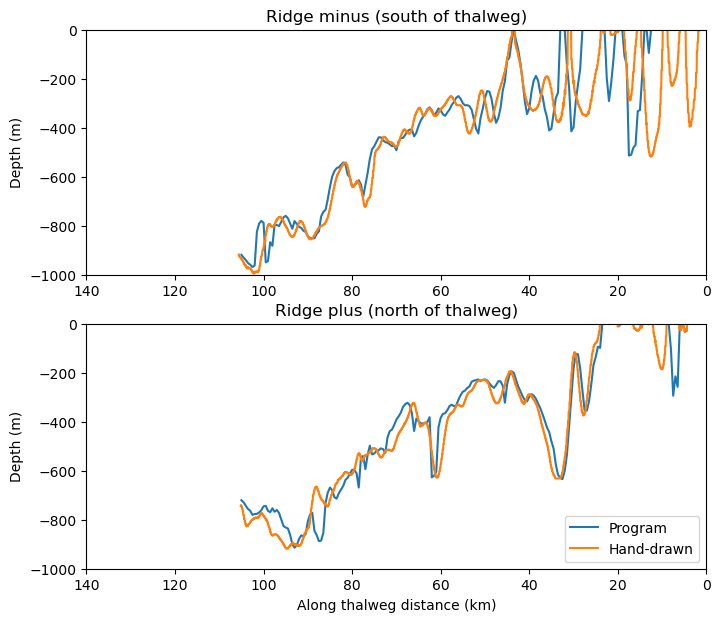

In [70]:
ridgeline_validation_plots(rink_drawn_ridge_minus, rink_ridge_minus_smooth_ds, rink_drawn_ridge_plus, rink_ridge_plus_smooth_ds, fjord='rink')

Kong Oscar

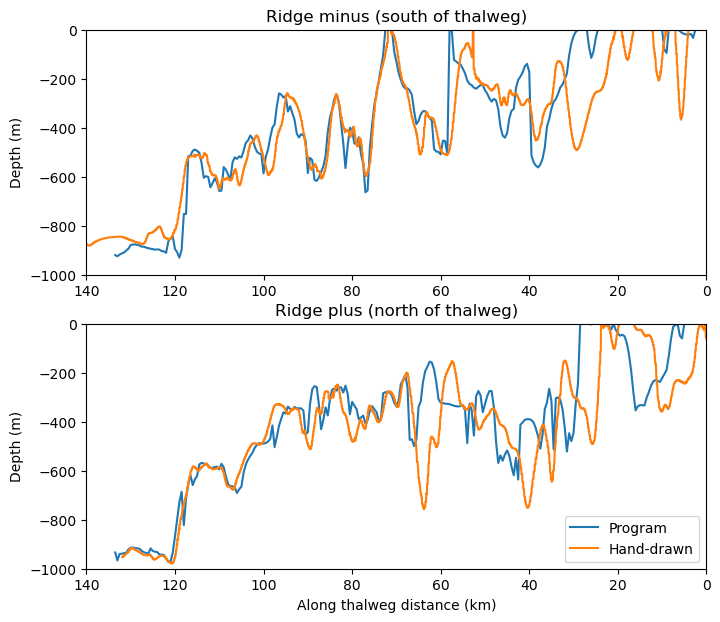

In [73]:
ridgeline_validation_plots(kong_drawn_ridge_minus, kong_ridge_minus_smooth_ds, kong_drawn_ridge_plus, kong_ridge_plus_smooth_ds, fjord='kong oscar')

Sverdrup

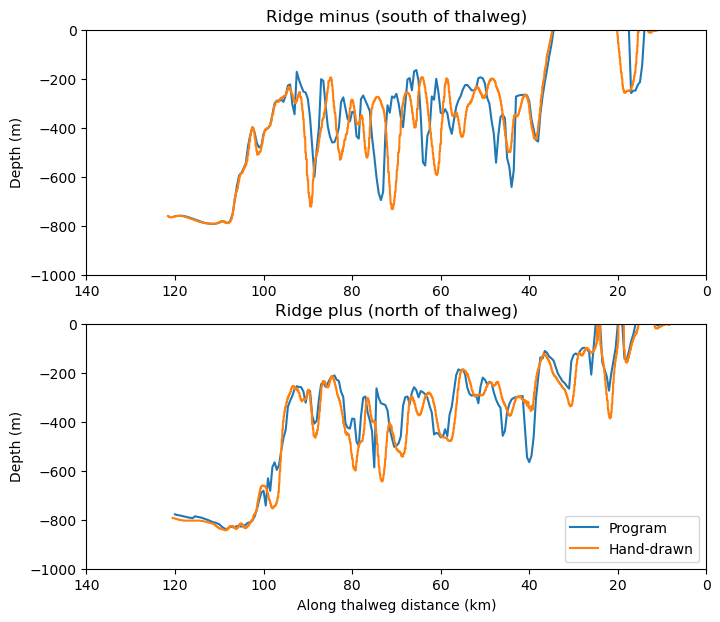

In [79]:
ridgeline_validation_plots(sver_drawn_ridge_minus, sver_ridge_minus_smooth_ds, sver_drawn_ridge_plus, sver_ridge_plus_smooth_ds, fjord='sverdrup')